In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata

In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

In [4]:
temp_data[0][0:10]

array([72.40000153, 73.90000153, 73.19999695, 71.5       , 72.90000153,
       74.19999695, 73.40000153, 74.19999695, 73.40000153, 73.19999695])

In [5]:
exogenous_observation_data[0][0:10]

array([  7.47240067,  12.22292137,  16.23451996,   0.        ,
        25.        , 288.79537964, 296.3588562 , 100.        ,
        60.        , 291.44784546])

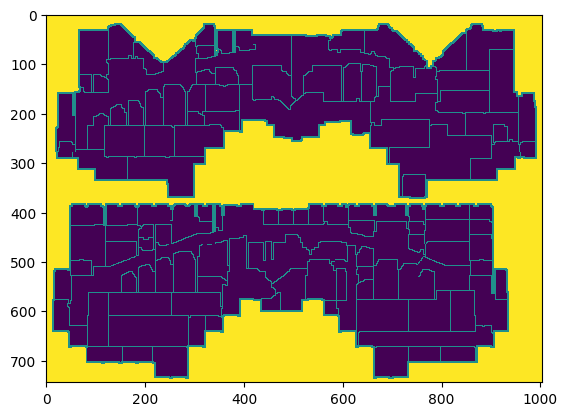

In [6]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [7]:
metadata["device_infos"][1]


{'device_id': '2760348383893915',
 'namespace': 'CDM',
 'code': 'VAV CO 1-1-10 CO2',
 'zone_id': '',
 'device_type': 4,
 'observable_fields': {'zone_air_heating_temperature_setpoint': 1,
  'zone_air_temperature_sensor': 1,
  'zone_air_co2_concentration_sensor': 1,
  'supply_air_flowrate_setpoint': 1,
  'zone_air_co2_concentration_setpoint': 1,
  'zone_air_cooling_temperature_setpoint': 1,
  'supply_air_flowrate_sensor': 1,
  'supply_air_damper_percentage_command': 1},
 'action_fields': {'supply_air_damper_percentage_command': 1,
  'supply_air_flowrate_setpoint': 1,
  'zone_air_heating_temperature_setpoint': 1,
  'zone_air_cooling_temperature_setpoint': 1,
  'zone_air_co2_concentration_setpoint': 1}}

In [8]:
# Assume metadata is already defined

unique_observable_fields = set()

for device in metadata["device_infos"]:
    observable_fields = device.get("observable_fields", {})
    unique_observable_fields.update(observable_fields.keys())

# Output the unique entries
print("Unique observable fields:")
for field in sorted(unique_observable_fields):
    print(field)


Unique observable fields:
building_air_static_pressure_sensor
building_air_static_pressure_setpoint
cooling_percentage_command
differential_pressure_sensor
differential_pressure_setpoint
discharge_air_temperature_sensor
discharge_air_temperature_setpoint
exhaust_air_damper_percentage_command
exhaust_air_damper_percentage_sensor
exhaust_fan_speed_frequency_sensor
exhaust_fan_speed_percentage_command
heating_water_valve_percentage_command
mixed_air_temperature_sensor
mixed_air_temperature_setpoint
outside_air_damper_percentage_command
outside_air_dewpoint_temperature_sensor
outside_air_flowrate_sensor
outside_air_flowrate_setpoint
outside_air_relative_humidity_sensor
outside_air_specificenthalpy_sensor
outside_air_temperature_sensor
outside_air_wetbulb_temperature_sensor
program_differential_pressure_setpoint
program_supply_air_static_pressure_setpoint
program_supply_air_temperature_setpoint
program_supply_water_temperature_setpoint
return_air_temperature_sensor
return_water_temperature_

In [9]:
unique_observable_fields = set()

for device in metadata["device_infos"]:
    code = device.get("code", "")
    if "VAV" in code:
        observable_fields = device.get("observable_fields", {})
        unique_observable_fields.update(observable_fields.keys())

# Output the unique entries
print("Unique observable fields for devices with 'VAV' in code:")
for field in sorted(unique_observable_fields):
    print(field)


Unique observable fields for devices with 'VAV' in code:
discharge_air_temperature_sensor
discharge_air_temperature_setpoint
heating_water_valve_percentage_command
supply_air_damper_percentage_command
supply_air_flowrate_sensor
supply_air_flowrate_setpoint
zone_air_co2_concentration_sensor
zone_air_co2_concentration_setpoint
zone_air_cooling_temperature_setpoint
zone_air_heating_temperature_setpoint
zone_air_temperature_sensor


In [10]:
unique_observable_fields = set()

for device in metadata["device_infos"]:
    code = device.get("code", "")
    if "SB1" in code:
        observable_fields = device.get("observable_fields", {})
        unique_observable_fields.update(observable_fields.keys())

# Output the unique entries
print("Unique observable fields for devices with 'SB' in code:")
for field in sorted(unique_observable_fields):
    print(field)

Unique observable fields for devices with 'SB' in code:
building_air_static_pressure_sensor
building_air_static_pressure_setpoint
cooling_percentage_command
differential_pressure_sensor
differential_pressure_setpoint
discharge_air_temperature_sensor
exhaust_air_damper_percentage_command
exhaust_air_damper_percentage_sensor
exhaust_fan_speed_frequency_sensor
exhaust_fan_speed_percentage_command
mixed_air_temperature_sensor
mixed_air_temperature_setpoint
outside_air_damper_percentage_command
outside_air_dewpoint_temperature_sensor
outside_air_flowrate_sensor
outside_air_flowrate_setpoint
outside_air_relative_humidity_sensor
outside_air_specificenthalpy_sensor
outside_air_temperature_sensor
outside_air_wetbulb_temperature_sensor
program_differential_pressure_setpoint
program_supply_air_static_pressure_setpoint
program_supply_air_temperature_setpoint
program_supply_water_temperature_setpoint
return_air_temperature_sensor
return_water_temperature_sensor
run_status
speed_frequency_sensor
spe

In [11]:
# Define the key you're searching for
target_key = 'outside_air_temperature_sensor'

# List to store matching devices
devices_with_key = []

for device in metadata["device_infos"]:
    observable_fields = device.get("observable_fields", {})
    if target_key in observable_fields:
        devices_with_key.append(device)

# # Output results
# print(f"Devices with '{target_key}' in observable_fields:")
# for device in devices_with_key:
#     print(f"- device_id: {device.get('device_id')}, code: {device.get('code')}")


In [12]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

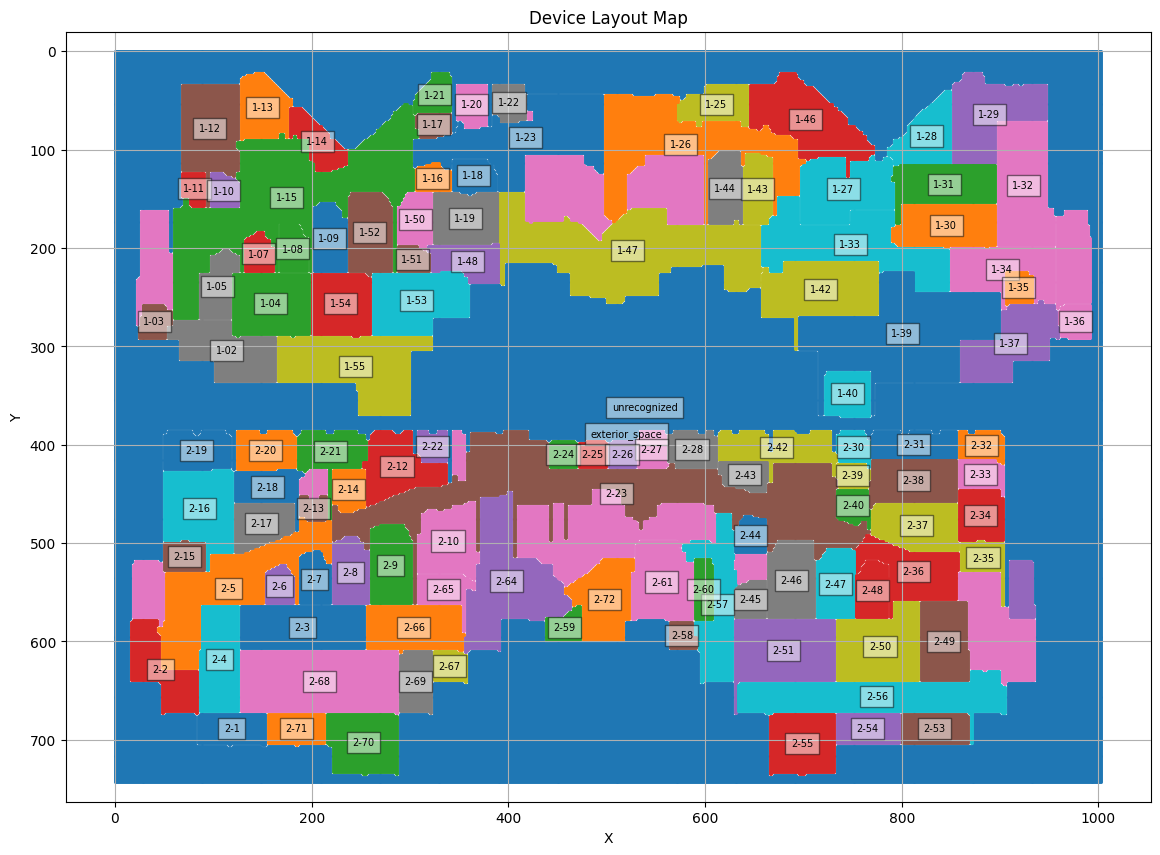

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
plt.figure(figsize=(14, 10))

for area_name, coords in device_layout_map.items():
    coords = np.array(coords)
    y_coords = coords[:, 0]
    x_coords = coords[:, 1]

    # Plot the points
    plt.scatter(x_coords, y_coords, label=area_name, s=1)

    # Calculate center to place label
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)
    plt.text(center_x, center_y, area_name, fontsize=7, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5))

# Aesthetics
plt.gca().invert_yaxis()  # Optional: flip Y axis if top-left is (0,0)
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Device Layout Map')
plt.axis('equal')  # Keeps aspect ratio square
plt.show()


In [14]:
print("All area names in device_layout_map:")
for key in device_layout_map:
    print(f"- {repr(key)}")


All area names in device_layout_map:
- 'exterior_space'
- '1-13'
- '1-21'
- '1-46'
- '1-29'
- '1-12'
- '1-20'
- '1-22'
- '1-25'
- '1-28'
- '1-23'
- '1-26'
- '1-15'
- '1-14'
- ''
- '1-17'
- '1-32'
- '1-44'
- '1-43'
- '1-27'
- '1-18'
- '1-16'
- '1-31'
- '1-11'
- '1-10'
- '1-52'
- '1-50'
- '1-19'
- '1-47'
- '1-33'
- '1-09'
- '1-30'
- '1-08'
- '1-07'
- '1-48'
- '1-51'
- '1-34'
- '1-05'
- '1-42'
- '1-53'
- '1-39'
- '1-35'
- '1-04'
- '1-54'
- '1-37'
- '1-03'
- '1-36'
- '1-02'
- '1-55'
- '1-40'
- '2-19'
- '2-20'
- '2-21'
- '2-12'
- '2-22'
- '2-23'
- '2-27'
- '2-28'
- '2-42'
- '2-30'
- '2-31'
- '2-32'
- '2-24'
- '2-25'
- '2-26'
- '2-38'
- '2-33'
- '2-43'
- '2-39'
- '2-16'
- '2-18'
- '2-14'
- '2-40'
- '2-34'
- '2-64'
- '2-13'
- '2-10'
- '2-17'
- '2-37'
- '2-57'
- '2-44'
- '2-5'
- '2-9'
- '2-36'
- '2-8'
- '2-15'
- '2-61'
- '2-46'
- '2-35'
- '2-47'
- '2-7'
- '2-72'
- '2-60'
- '2-48'
- '2-6'
- '2-49'
- '2-65'
- '2-45'
- '2-50'
- '2-4'
- '2-3'
- '2-66'
- '2-59'
- '2-2'
- '2-51'
- '2-58'
- '2-68'
- 

In [15]:
print("Contents of 'unrecognized':")
print(device_layout_map.get('unrecognized'))


Contents of 'unrecognized':
[[62, 420], [63, 420], [62, 421], [63, 421], [62, 422], [63, 422], [62, 423], [63, 423], [64, 420], [65, 420], [64, 421], [65, 421], [64, 422], [65, 422], [64, 423], [65, 423], [106, 418], [107, 418], [106, 419], [107, 419], [106, 420], [107, 420], [106, 421], [107, 421], [106, 422], [107, 422], [106, 423], [107, 423], [106, 424], [107, 424], [106, 425], [107, 425], [106, 426], [107, 426], [106, 427], [107, 427], [106, 428], [107, 428], [106, 429], [107, 429], [106, 430], [107, 430], [106, 431], [107, 431], [106, 432], [107, 432], [106, 433], [107, 433], [106, 434], [107, 434], [106, 435], [107, 435], [106, 436], [107, 436], [106, 437], [107, 437], [106, 438], [107, 438], [106, 439], [107, 439], [106, 440], [107, 440], [106, 441], [107, 441], [106, 442], [107, 442], [106, 443], [107, 443], [106, 444], [107, 444], [106, 445], [107, 445], [106, 446], [107, 446], [106, 447], [107, 447], [106, 448], [107, 448], [106, 449], [107, 449], [106, 450], [107, 450], [10

In [16]:
import re
import pandas as pd
device_list = []

for device in metadata['device_infos']:
    device_id = device.get('device_id', '')
    namespace = device.get('namespace', '')
    code = device.get('code', '')
    device_type = device.get('device_type', '')
    
    match = re.search(r'(\d+)-(\d+)-(\d+)', code)
    if match:
        second_part = match.group(2)
        third_part = match.group(3)
        simplified_code = f"{second_part}-{third_part}"
    else:
        simplified_code = ''
    
    device_list.append({
        'device_id': device_id,
        'namespace': namespace,
        'code': code,
        'code_simple': simplified_code,
        'device_type': device_type
    })

device_df = pd.DataFrame(device_list)
device_df.head(5)

,device_id,namespace,code,code_simple,device_type
0,202194278473007104,PHRED,SB1:AHU:AC-2,,6
1,2760348383893915,CDM,VAV CO 1-1-10 CO2,1-10,4
2,2562701969438717,CDM,VAV CO 2-2-36,2-36,4
3,2806035809406684,CDM,,,4
4,2790439929052995,CDM,VAV CO 1-1-43,1-43,4


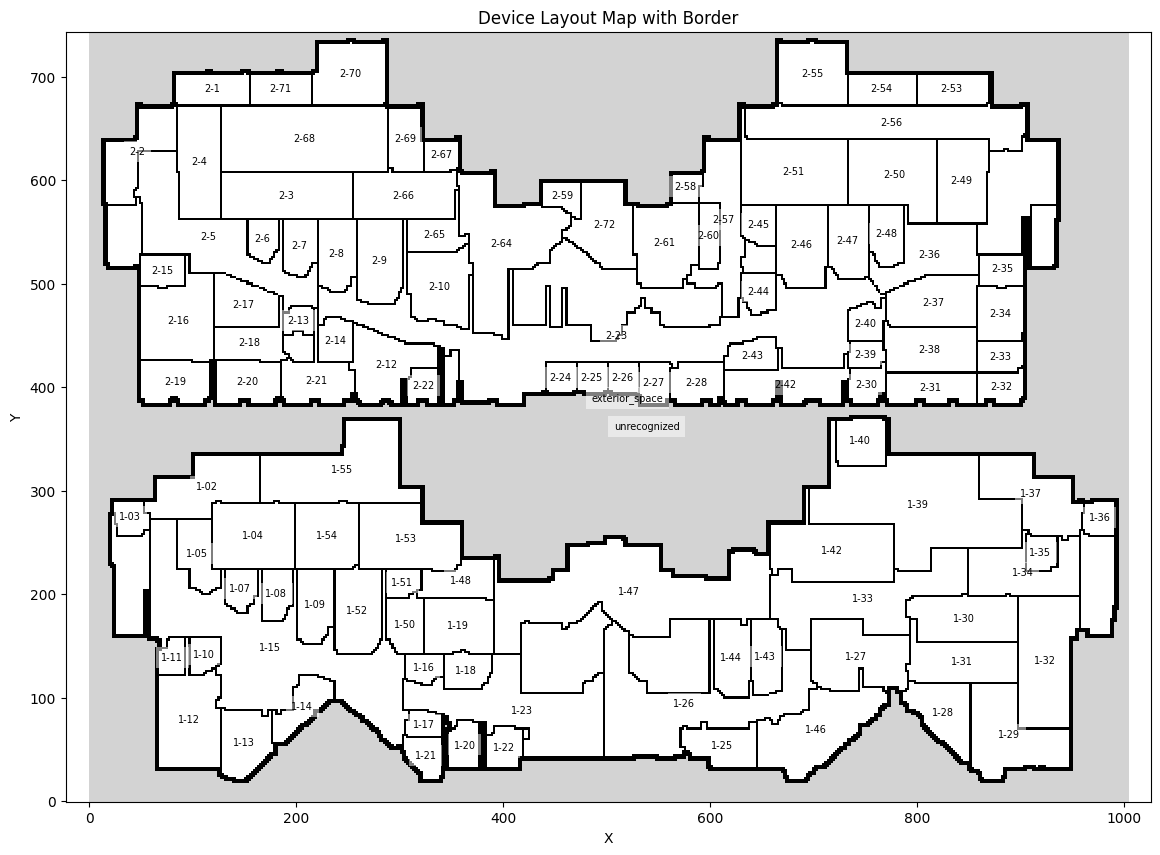

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assume this is your 744x1004 array
# Replace with your actual variable name
grid = floorplan  # shape (744, 1004), with values 0 (interior), 1 (border), 2 (external)

# Plot it
plt.figure(figsize=(14, 10))
cmap = ListedColormap(['white', 'black', 'lightgray'])  # 0: white, 1: black, 2: lightgray
plt.imshow(grid, cmap=cmap, interpolation='none')

# Overlay device_layout_map region labels
for area_name, coords in device_layout_map.items():
    coords = np.array(coords)
    y_coords = coords[:, 0]
    x_coords = coords[:, 1]
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)
    plt.text(center_x, center_y, area_name, fontsize=7, ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

plt.title("Device Layout Map with Border")
plt.xlabel("X")
plt.ylabel("Y")
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()


In [18]:
from collections import defaultdict

# Step 1: Build label grid (same size as the main grid)
region_grid = np.full(grid.shape, fill_value='', dtype=object)

# Fill in region labels
for area_name, coords in device_layout_map.items():
    for y, x in coords:
        region_grid[y, x] = area_name

# Step 2: Detect neighbors via borders
adjacency_map = defaultdict(set)

# Offsets to check neighboring cells
offsets = [(-4,0), (4,0), (0,-4), (0,4)]

for y in range(1, grid.shape[0] - 1):
    for x in range(1, grid.shape[1] - 1):
        if grid[y, x] == 1:  # border
            neighboring_regions = set()
            for dy, dx in offsets:
                ry, rx = y + dy, x + dx
                label = region_grid[ry, rx]
                if label:
                    neighboring_regions.add(label)
            # Record mutual adjacency
            for r1 in neighboring_regions:
                for r2 in neighboring_regions:
                    if r1 != r2:
                        adjacency_map[r1].add(r2)

# Print adjacency results
print("\nCluster Adjacency Map (based on border contact):")
for cluster, neighbors in adjacency_map.items():
    print(f"{cluster} is adjacent to: {', '.join(neighbors)}")



Cluster Adjacency Map (based on border contact):
1-13 is adjacent to: 1-15, 1-12, 1-14, exterior_space
exterior_space is adjacent to: 2-68, 1-37, 1-27, 1-40, 2-69, 1-42, 2-57, 2-55, 1-55, 2-71, 1-14, 2-56, 2-35, 2-18, 2-32, 2-30, 1-26, 2-1, 1-53, 2-16, 2-54, 1-21, 1-46, 1-22, 2-51, 2-20, 2-72, 1-03, 2-42, 2-24, 1-13, 2-23, 2-26, 2-58, 2-19, 1-23, 1-11, 2-33, unrecognized, 2-31, 1-25, 2-61, 2-28, 2-59, 2-34, 2-67, 2-64, 1-32, 1-36, 1-39, 2-70, 1-15, 2-25, 1-12, 1-28, 1-20, 2-53, 2-21, 2-2, 1-17, 2-12, 2-22, 1-47, 1-48, 2-27, 2-15, 1-02, 1-29
1-21 is adjacent to: 1-15, 1-17, 1-20, exterior_space
1-46 is adjacent to: 1-25, 1-26, 1-27, exterior_space
1-29 is adjacent to: 1-32, 1-31, 1-28, exterior_space
1-12 is adjacent to: 1-15, 1-11, exterior_space, 1-13, 1-10
1-20 is adjacent to: 1-23, 1-22, exterior_space, 1-17, 1-21
1-22 is adjacent to: unrecognized, 1-23, 1-20, exterior_space
1-25 is adjacent to: 1-46, 1-26, exterior_space
1-28 is adjacent to: 1-31, 1-29, 1-27, exterior_space
1-23 i

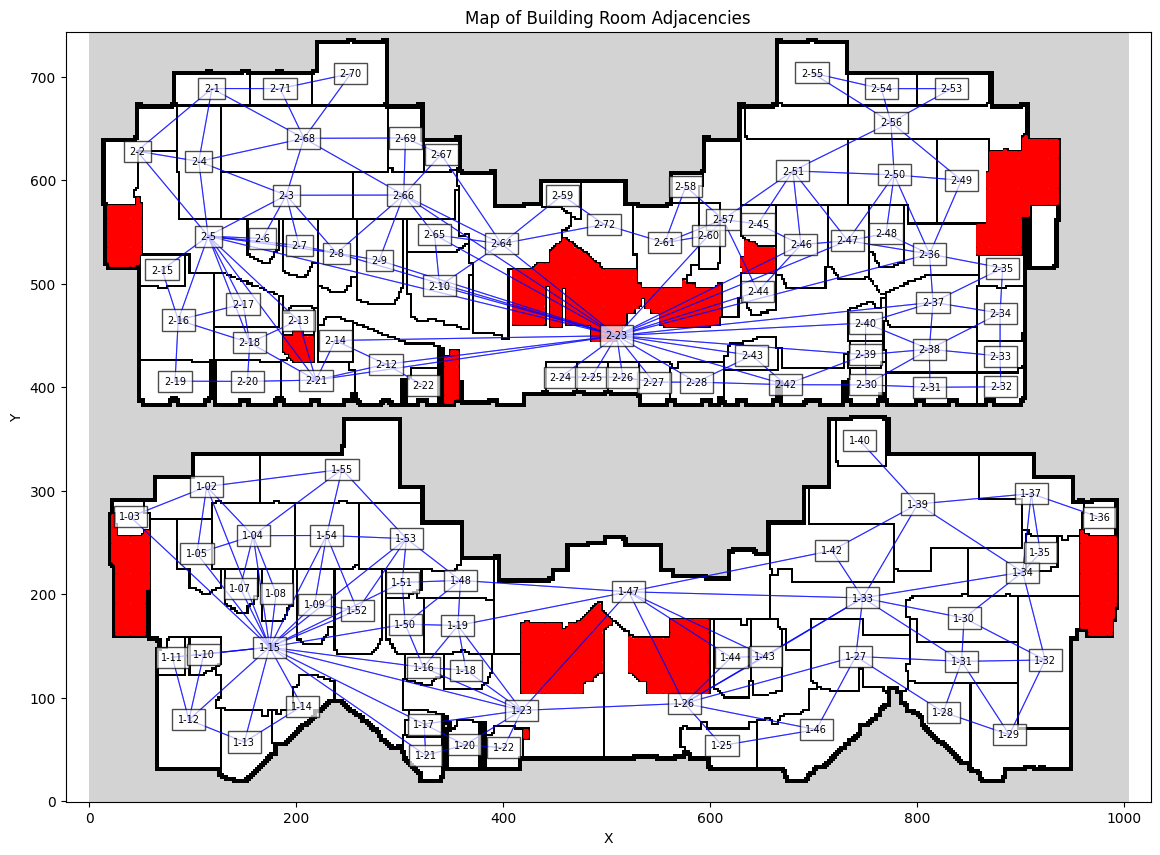

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Example colors: 0 = interior (white), 1 = border (black), 2 = external (gray)
cmap = ListedColormap(['white', 'black', 'lightgray'])

# Step 1: Build cluster center lookup
cluster_centers = {}
for area_name, coords in device_layout_map.items():
    coords = np.array(coords)
    y_coords = coords[:, 0]
    x_coords = coords[:, 1]
    center_y = np.mean(y_coords)
    center_x = np.mean(x_coords)
    cluster_centers[area_name] = (center_x, center_y)

# Step 2: Plot base grid
plt.figure(figsize=(14, 10))
plt.imshow(grid, cmap=cmap, interpolation='none')

# Step 3: Draw edges between adjacent cluster centers
for cluster, neighbors in adjacency_map.items():
    if cluster in ['exterior_space', 'unrecognized']:
        continue
    for neighbor in neighbors:
        if neighbor in ['exterior_space', 'unrecognized']:
            continue
        if neighbor in cluster_centers:
            x1, y1 = cluster_centers[cluster]
            x2, y2 = cluster_centers[neighbor]
            plt.plot([x1, x2], [y1, y2], color='blue', linewidth=0.8, alpha=0.6)

# Step 4: Draw and label cluster centers
for area_name, (x, y) in cluster_centers.items():
    if area_name == 'exterior_space':
        continue
        # plt.text(x, y, area_name, fontsize=7, ha='center', va='center',
        #          bbox=dict(facecolor='lightblue', alpha=0.8))
    elif area_name == 'unrecognized':
        continue
        # plt.text(x, y, area_name, fontsize=7, ha='center', va='center',
        #          bbox=dict(facecolor='lightcoral', alpha=0.8))
    else:
        plt.text(x, y, area_name, fontsize=7, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7))

if 'unrecognized' in device_layout_map:
    coords = np.array(device_layout_map['unrecognized'])
    y_coords = coords[:, 0]
    x_coords = coords[:, 1]
    plt.scatter(x_coords, y_coords, color='red', s=1)

    
# Final plot settings
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title('Map of Building Room Adjacencies')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(False)
plt.show()


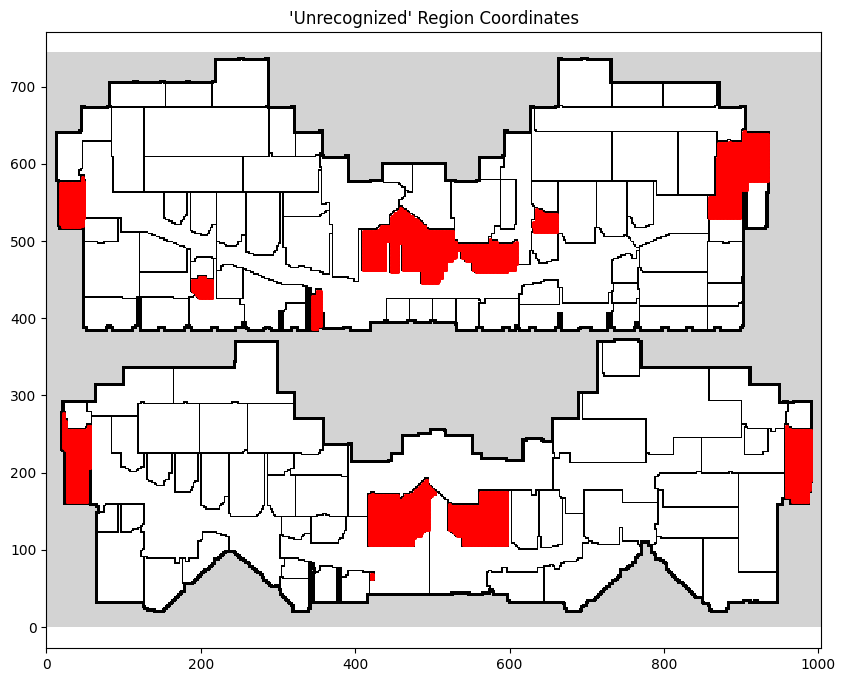

In [20]:
if 'unrecognized' in device_layout_map:
    coords = np.array(device_layout_map['unrecognized'])
    y_coords = coords[:, 0]
    x_coords = coords[:, 1]
    plt.figure(figsize=(10, 8))
    plt.imshow(grid, cmap=cmap, interpolation='none')
    plt.scatter(x_coords, y_coords, color='red', s=1)
    plt.title("'Unrecognized' Region Coordinates")
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()


In [21]:
#2779591174908667

print(temp_data_ids.get('2779591174908667@zone_air_temperature_sensor'))



20


In [22]:
print(temp_data[:,10])

[74.19999695 74.19999695 74.19999695 ... 65.59999847 65.59999847
 65.59999847]
